In [4]:
!pip install opendatasets

In [5]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/balabaskar/cricket-legends-in-world-image-dataset?select=cricket_legends.csv")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: manvendra9694
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/balabaskar/cricket-legends-in-world-image-dataset


100%|██████████| 389M/389M [00:03<00:00, 121MB/s] 


In [6]:
import pandas as pd
data = pd.read_csv("/content/cricket-legends-in-world-image-dataset/cricket_legends.csv")
data.head()


folder_name        filename
0  adam_gilchrist  0089e58895.jpg
1  adam_gilchrist  00a53b4482.jpg
2  adam_gilchrist  00abc353f4.jpg
3  adam_gilchrist  02007f2216.jpg
4  adam_gilchrist  038144ecd5.jpg

In [7]:
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt

In [8]:
image_size = (180, 180)
batch_size = 128

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "/content/cricket-legends-in-world-image-dataset",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 6948 files belonging to 1 classes.
Using 5559 files for training.
Using 1389 files for validation.


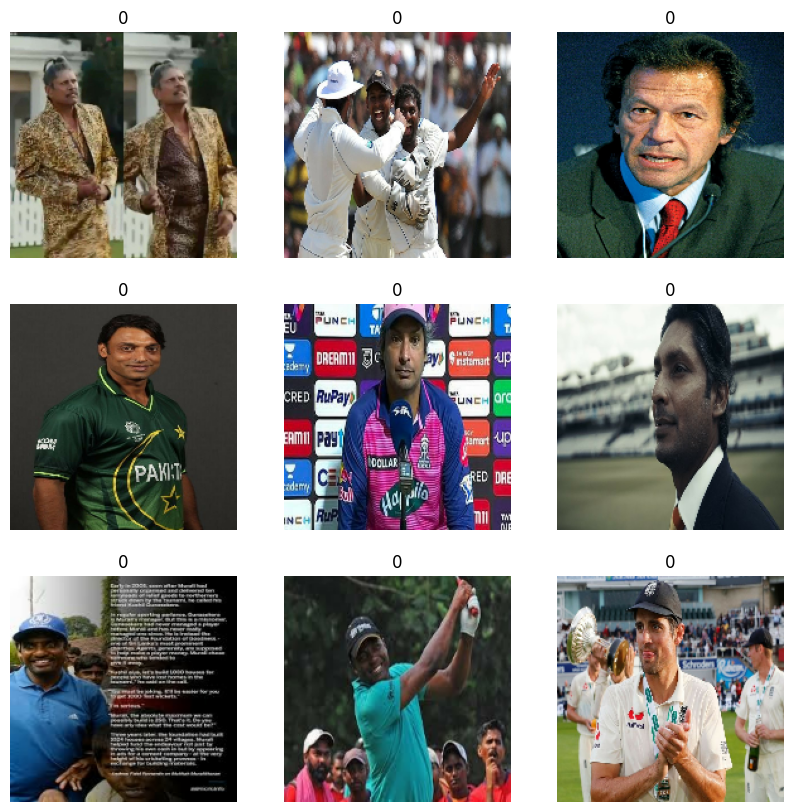

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [10]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

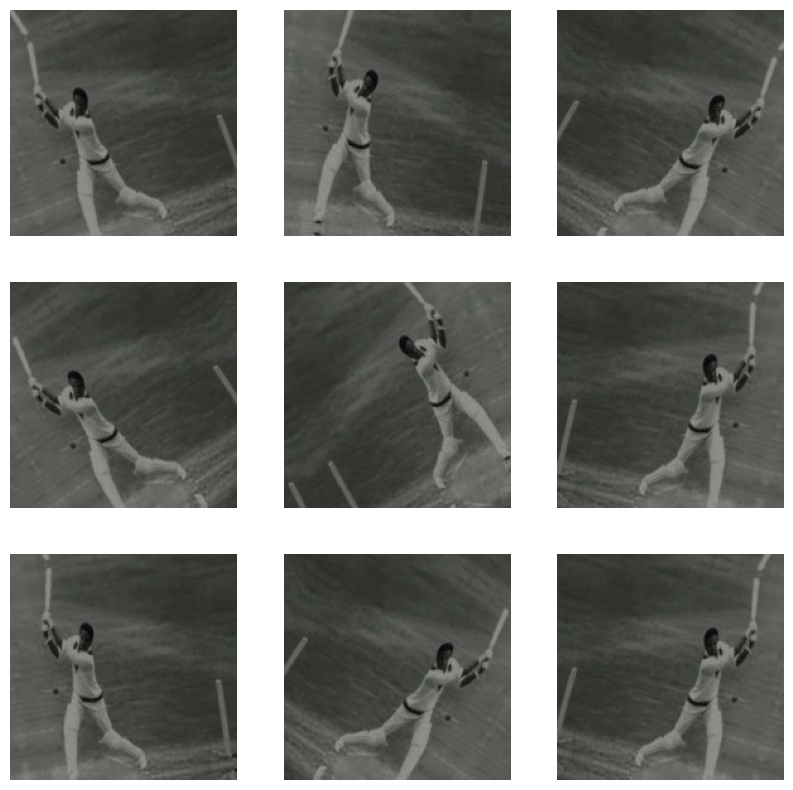

In [11]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

In [9]:
inputs = keras.Input(shape=image_size + (3,))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)

In [12]:
augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))


In [13]:
from tensorflow import keras
from tensorflow.keras import layers

# Define the model
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(
            size, 1, strides=2, padding="same")(previous_block_activation)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes > 2:
        activation = "softmax"
        units = num_classes
    else:
        activation = "sigmoid"
        units = 1

    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

# Since the dataset only has one class ('cricket-legends-in-world-image-dataset'),
# the number of classes is 1.
num_classes = 1
model = make_model(image_size + (3,), num_classes)

In [12]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

In [14]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)


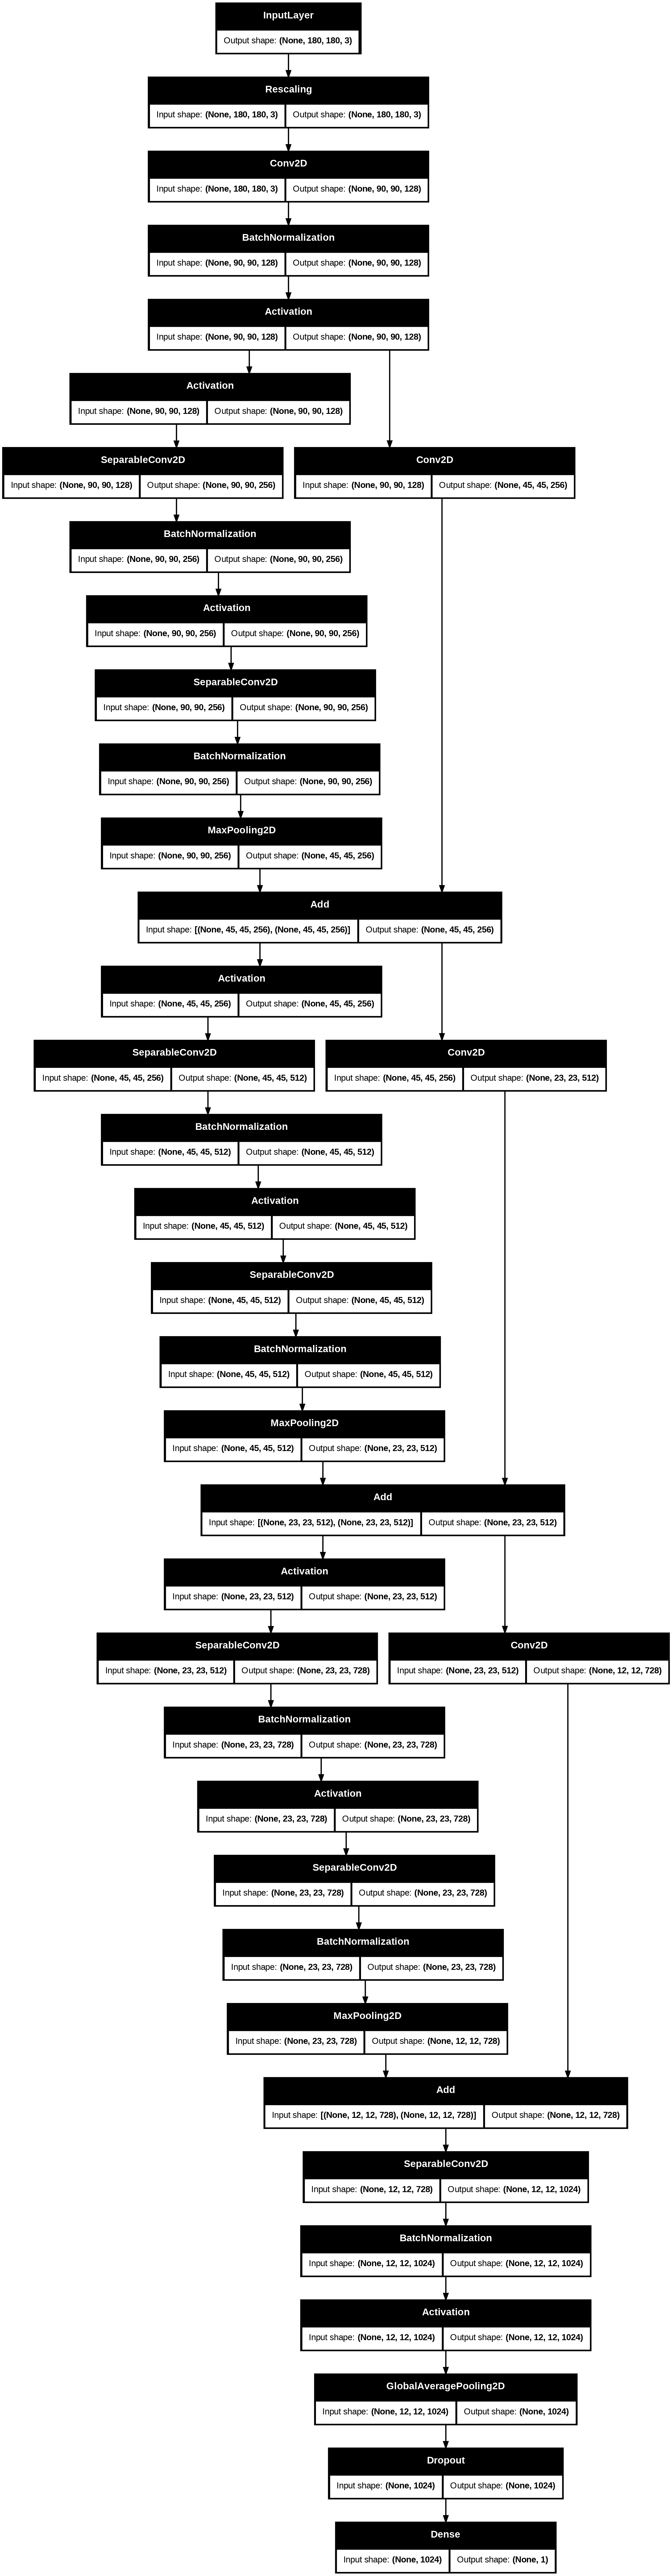

In [15]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [16]:
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

In [17]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available: 0


In [18]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/cricket-legends-in-world-image-dataset",
    image_size=(128, 128),   # smaller images
    batch_size=16            # smaller batch size
)

Found 6948 files belonging to 1 classes.


In [19]:
from tensorflow import keras
from tensorflow.keras import layers

# Define the model
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(
            size, 1, strides=2, padding="same")(previous_block_activation)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes > 2:
        activation = "softmax"
        units = num_classes
    else:
        activation = "sigmoid"
        units = 1

    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

# Since the dataset only has one class ('cricket-legends-in-world-image-dataset'),
# the number of classes is 1.
num_classes = 1
image_size = (128, 128) # Correcting image size to match the dataset
model = make_model(image_size + (3,), num_classes)

In [20]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [21]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/cricket-legends-in-world-image-dataset",
    image_size=(128, 128),   # 🔹 MUST match model input size
    batch_size=32,
    validation_split=0.2,
    subset="training",
    seed=123
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/cricket-legends-in-world-image-dataset",
    image_size=(128, 128),   # 🔹 Same size here too
    batch_size=32,
    validation_split=0.2,
    subset="validation",
    seed=123
)


Found 6948 files belonging to 1 classes.
Using 5559 files for training.
Found 6948 files belonging to 1 classes.
Using 1389 files for validation.


In [91]:
from tensorflow.keras import layers, models

num_classes = 2  # Cat and Cricketer

model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(img_size[0], img_size[1], 3)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)  # output 2 neurons (logits)
])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [92]:
import tensorflow as tf

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)


In [93]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)


Epoch 1/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 239s 1s/step - accuracy: 0.9795 - loss: 0.0230 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 234s 1s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 257s 1s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 235s 1s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 233s 1s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 258s 1s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 268s 1s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 236s 

In [94]:
model.save("/content/cat_cricketer_model.keras")


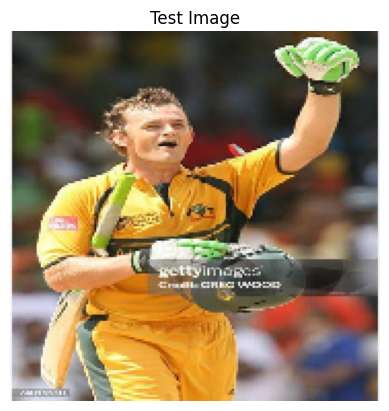

Model input shape: (None, 180, 180, 3)
Image array shape: (1, 180, 180, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
This image is 100.00% likely to be a CRICKETER.


In [101]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np # Import numpy

# 🔧 Must match model input size
image_size = (180, 180)   # or (180, 180) if your model was trained with that

# Load and display image
img_path = "/content/gil image.jpg"
img = keras.utils.load_img(img_path, target_size=image_size)
plt.imshow(img)
plt.title("Test Image")
plt.axis("off")
plt.show()

# Convert to array and add batch dimension
img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Add batch dimension

# Print model input shape for debugging
print("Model input shape:", model.input_shape)
print("Image array shape:", img_array.shape)


# Predict
predictions = model.predict(img_array)

# Convert logits → probability
score = float(tf.sigmoid(predictions[0][0]))

# Interpret result
if score > 0.5:
    print(f"This image is {100 * score:.2f}% likely to be a CRICKETER.")
else:
    print(f"This image is {100 * (1 - score):.2f}% likely to be a NON-CRICKETER.")

In [22]:
keras.layers.Rescaling(1./255, input_shape=(128,128,3))


/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


<Rescaling name=rescaling_3, built=False>

In [24]:
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/nn.py:789: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


174/174 ━━━━━━━━━━━━━━━━━━━━ 528s 3s/step - acc: 0.9979 - loss: 0.0611 - val_acc: 1.0000 - val_loss: 0.0303
Epoch 2/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 518s 3s/step - acc: 1.0000 - loss: 6.0742e-04 - val_acc: 1.0000 - val_loss: 4.2008e-04
Epoch 3/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 565s 3s/step - acc: 1.0000 - loss: 2.8446e-04 - val_acc: 1.0000 - val_loss: 8.3703e-04
Epoch 4/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 525s 3s/step - acc: 1.0000 - loss: 1.7469e-04 - val_acc: 1.0000 - val_loss: 4.7239e-04
Epoch 5/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 551s 3s/step - acc: 1.0000 - loss: 1.2070e-04 - val_acc: 1.0000 - val_loss: 1.1483e-04
Epoch 6/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 511s 3s/step - acc: 1.0000 - loss: 8.9732e-05 - val_acc: 1.0000 - val_loss: 7.5594e-05
Epoch 7/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 510s 3s/step - acc: 1.0000 - loss: 6.9638e-05 - val_acc: 1.0000 - val_loss: 5.9171e-05
Epoch 8/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 523s 3s/step - acc: 1.0000 - loss: 5.5930e-05 - val_acc: 1.0000 - val_loss: 4.8285e-05
Epo

In [77]:
save_model_path = "/content/cricket_legend_model.keras" # Added .keras extension
model.save(save_model_path)

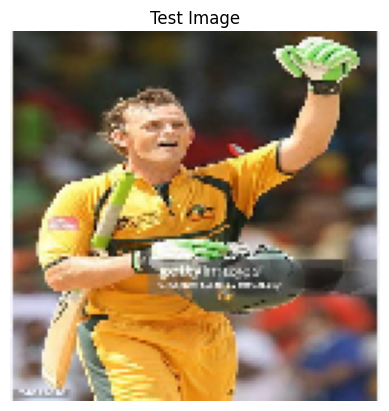

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
This image is 50.01% likely to be a CRICKETER.


In [40]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

# Must match model input
image_size = (128, 128)

# Load and display image
img_path = "/content/gil image.jpg"
img = keras.utils.load_img(img_path, target_size=image_size)
plt.imshow(img)
plt.title("Test Image")
plt.axis("off")
plt.show()

# Convert to array and add batch dimension
img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Add batch dimension

# Predict
predictions = model.predict(img_array)

# Convert logits → probability
score = float(tf.sigmoid(predictions[0][0]))

# Interpret result
if score > 0.5:
    print(f"This image is {100 * score:.2f}% likely to be a CRICKETER.")
else:
    print(f"This image is {100 * (1 - score):.2f}% likely to be a NON-CRICKETER.")


In [28]:
# 1. Print dataset class names and class indices
print("train_ds:", getattr(train_ds, "class_names", None))
print("val_ds:", getattr(val_ds, "class_names", None))

# If you created train_ds using image_dataset_from_directory
if hasattr(train_ds, "class_names"):
    print("Class order (train_ds.class_names):", train_ds.class_names)

# 2. Confirm model input shape
print("Model input shape:", model.input_shape)

# 3. Show one batch shape from the dataset
for images, labels in train_ds.take(1):
    print("Dataset batch image shape:", images.shape)
    print("Dataset batch label sample:", labels[:10].numpy())
    break


train_ds: ['Cricket Legends']
val_ds: ['Cricket Legends']
Class order (train_ds.class_names): ['Cricket Legends']
Model input shape: (None, 128, 128, 3)
Dataset batch image shape: (32, 128, 128, 3)
Dataset batch label sample: [0 0 0 0 0 0 0 0 0 0]


In [30]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

image_size = (128, 128)   # must match training
img_path = "/content/cat_image.jpg"

# load & resize exactly as training
img = keras.utils.load_img(img_path, target_size=image_size)
img_array = keras.utils.img_to_array(img)        # shape (H,W,3)
img_array = img_array / 255.0                    # if you used Rescaling during training
img_batch = np.expand_dims(img_array, axis=0)    # shape (1,H,W,3)

# Predict
logit = model.predict(img_batch)                 # shape (1,1) for binary
prob = tf.sigmoid(logit).numpy().squeeze()      # probability for positive class

print("Logit:", logit, "Probability:", prob)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
Logit: [[0.00024332]] Probability: 0.50006086


In [31]:
# If you used image_dataset_from_directory
print("train class names:", train_ds.class_names)
# class_names[0] -> label 0, class_names[1] -> label 1

# Suppose class_names = ['cat', 'cricketer']
# then model output probability (sigmoid) close to 1 means 'cricketer'


train class names: ['Cricket Legends']


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step


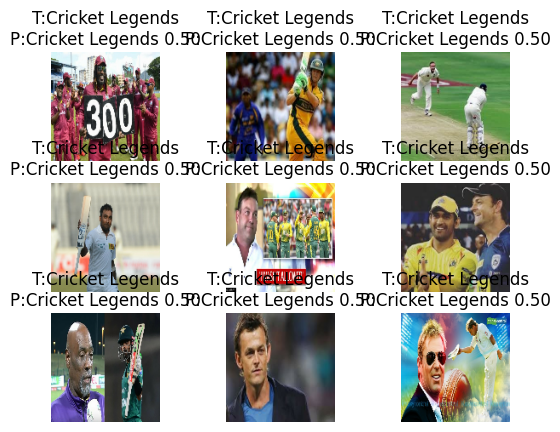

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# visualize few examples from validation set
i = 0
for imgs, lbls in val_ds.unbatch().batch(9).take(1):
    imgs_np = imgs.numpy()
    lbls_np = lbls.numpy()
    preds = model.predict(imgs_np)
    probs = tf.sigmoid(preds).numpy().squeeze()
    for j in range(len(imgs_np)):
        plt.subplot(3,3,j+1)
        plt.imshow((imgs_np[j].astype("uint8")))
        # Correctly handle single class
        true_label = val_ds.class_names[0] if int(lbls_np[j]) == 0 else "Unknown" # Assuming label 0 for the single class
        pred_label = val_ds.class_names[0] if probs[j] > 0.5 else "Not Cricket Legend" # Assuming > 0.5 means the single class
        plt.title(f"T:{true_label}\nP:{pred_label} {probs[j]:.2f}")
        plt.axis("off")
    plt.show()
    break

In [33]:
# If using saved checkpoints:
model = keras.models.load_model("save_at_4.keras")   # or "best_model.keras"
print("Loaded model summary:")
model.summary()


Loaded model summary:


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 128, 128,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 64, 64,    │        896 │ rescaling_2[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_19       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 64, 64,    │     18,496 │ activation_19[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_20       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_21       │ (None, 64, 64,    │          0 │ activation_20[0]… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_16 │ (None, 64, 64,    │      8,896 │ activation_21[0]… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ separable_conv2d… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_22       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_17 │ (None, 64, 64,    │     17,664 │ activation_22[0]… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ separable_conv2d… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 32, 32,    │      8,320 │ activation_20[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, 32, 32,    │          0 │ max_pooling2d_7[

 Total params: 8,330,477 (31.78 MB)

 Trainable params: 2,773,913 (10.58 MB)

 Non-trainable params: 8,736 (34.12 KB)

 Optimizer params: 5,547,828 (21.16 MB)

In [34]:
preds = model.predict(img_batch)       # shape (1, C)
probs = tf.nn.softmax(preds[0]).numpy()
pred_idx = np.argmax(probs)
print("Predicted:", train_ds.class_names[pred_idx], "Prob:", probs[pred_idx])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
Predicted: Cricket Legends Prob: 1.0


In [35]:
import tensorflow as tf
from collections import Counter

class_counts = Counter()

for _, labels in train_ds:
    labels = labels.numpy().astype(int)
    class_counts.update(labels)

# Print counts
print("Image counts per class:")
for i, count in class_counts.items():
    print(f"Class {i} ({train_ds.class_names[i]}): {count} images")


Image counts per class:
Class 0 (Cricket Legends): 5559 images


In [36]:
from sklearn.utils import class_weight
import numpy as np

y_train = []
for _, labels in train_ds:
    y_train.extend(labels.numpy().astype(int))
y_train = np.array(y_train)

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights_dict = dict(enumerate(class_weights))
print("Class weights:", class_weights_dict)


Class weights: {0: np.float64(1.0)}


In [37]:
preds = model.predict(val_ds)
probs = tf.sigmoid(preds).numpy().squeeze()
print("Sample probabilities:", probs[:10])


44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 648ms/step
Sample probabilities: [0.50011814 0.50021195 0.5001248  0.50012255 0.50012875 0.5001045
 0.500095   0.5000992  0.500104   0.50008434]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


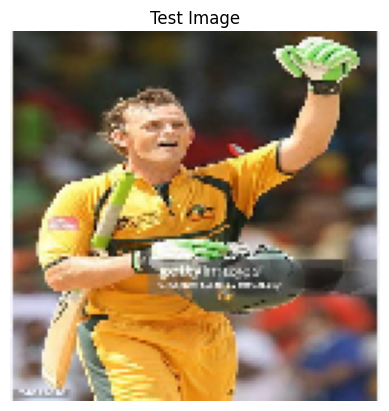

Prediction: Cricket Legends (50.03% confidence)


In [44]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np

# 🔧 Must match model input size
image_size = (128, 128)   # or (180, 180) if your model was trained with that

# 📸 Path to uploaded file
img_path = "/content/gil image.jpg"   # <-- change this to your uploaded image

# 🧩 Load and preprocess image
img = keras.utils.load_img(img_path, target_size=image_size)
img_array = keras.utils.img_to_array(img)
img_array = img_array / 255.0   # only if you used Rescaling(1./255) in training
img_batch = np.expand_dims(img_array, axis=0)  # shape (1, H, W, 3)

# 🔮 Predict
pred = model.predict(img_batch)
prob = tf.sigmoid(pred).numpy().squeeze()

# 🎨 Show the image
plt.imshow(img)
plt.title("Test Image")
plt.axis("off")
plt.show()

# 🧠 Interpret prediction
class_names = train_ds.class_names  # ['Cricket Legends']

if prob > 0.5:
    # Assuming 'Cricket Legends' is the positive class (represented by probability > 0.5)
    print(f"Prediction: {class_names[0]} ({prob*100:.2f}% confidence)")
else:
    # Assuming anything below 0.5 is not a Cricket Legend
    print(f"Prediction: Not {class_names[0]} ({(1-prob)*100:.2f}% confidence)")

In [48]:
loss, accuracy = model.evaluate(val_ds)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")
print(f"Validation Loss: {loss:.4f}")


/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/nn.py:789: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 595ms/step - acc: 1.0000 - loss: 4.7293e-04
Validation Accuracy: 100.00%
Validation Loss: 0.0005


In [50]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/mahmudulhaqueshawon/cat-image")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: manvendra9694
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/mahmudulhaqueshawon/cat-image


100%|██████████| 47.9M/47.9M [00:00<00:00, 1.48GB/s]

In [55]:
import os

data_dir = "/content/cat-image"
os.listdir(data_dir)


['cats']

In [56]:
from tensorflow import keras
from tensorflow.keras import layers

img_size = (180, 180)
batch_size = 32

train_ds = keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=img_size,
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=123,
)

val_ds = keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=img_size,
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=123,
)


Found 15747 files belonging to 1 classes.
Using 12598 files for training.
Found 15747 files belonging to 1 classes.
Using 3149 files for validation.


In [69]:
model = keras.Sequential([
    keras.Input(shape=(180, 180, 3)), # Explicitly define input shape
    layers.Rescaling(1./255),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    # layers.Dense(128, activation='relu'), # Removed this layer to simplify
    layers.Dense(1)  # binary classification
])

In [58]:
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)


Epoch 1/5
394/394 ━━━━━━━━━━━━━━━━━━━━ 520s 1s/step - accuracy: 1.0000 - loss: 0.0127 - val_accuracy: 1.0000 - val_loss: 1.3112e-07
Epoch 2/5
394/394 ━━━━━━━━━━━━━━━━━━━━ 512s 1s/step - accuracy: 1.0000 - loss: 9.9248e-08 - val_accuracy: 1.0000 - val_loss: 2.2192e-08
Epoch 3/5
394/394 ━━━━━━━━━━━━━━━━━━━━ 557s 1s/step - accuracy: 1.0000 - loss: 1.9232e-08 - val_accuracy: 1.0000 - val_loss: 7.2319e-09
Epoch 4/5
394/394 ━━━━━━━━━━━━━━━━━━━━ 512s 1s/step - accuracy: 1.0000 - loss: 6.1929e-09 - val_accuracy: 1.0000 - val_loss: 3.4202e-09
Epoch 5/5
394/394 ━━━━━━━━━━━━━━━━━━━━ 520s 1s/step - accuracy: 1.0000 - loss: 3.4235e-09 - val_accuracy: 1.0000 - val_loss: 1.9608e-09


In [78]:
save_model_path = "/content/cat_model.keras" # Added .keras extension
model.save(save_model_path)

In [90]:
from tensorflow.keras.utils import image_dataset_from_directory

dataset_dir = "/content/cricket-legends-in-world-image-dataset"  # Folder containing 'Cat' and 'Cricketer'
img_size = (180, 180)
batch_size = 32

# Training dataset (80% of data)
train_ds = image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

# Validation dataset (20% of data)
val_ds = image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)


Found 6948 files belonging to 1 classes.
Using 5559 files for training.
Found 6948 files belonging to 1 classes.
Using 1389 files for validation.


In [88]:
cricketer_model.input_shape


(None, 180, 180, 3)

In [80]:
from tensorflow import keras
import numpy as np

img_path = "/content/gil image.jpg"
expected_size = (180, 180)  # replace with cricketer_model.input_shape[1:3]

img = keras.utils.load_img(img_path, target_size=expected_size)
img_array = keras.utils.img_to_array(img) / 255.0
img_batch = np.expand_dims(img_array, axis=0)


In [81]:
cricketer_pred = cricketer_model.predict(img_batch)
cricketer_score = float(tf.sigmoid(cricketer_pred)[0][0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


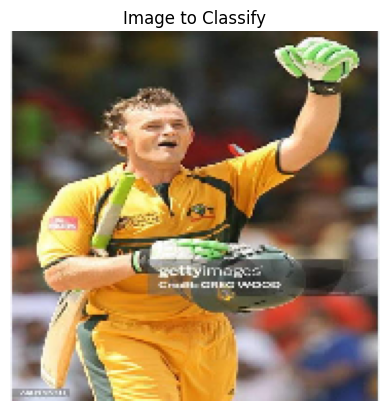

This image is predicted as **Cricketer** with confidence 50.00%
(Debug) Cricketer score: 0.5000, Cat score: 0.5000)


In [87]:
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf

# -------------------------------
# Path to test image
# -------------------------------
img_path = "/content/gil image.jpg"

# -------------------------------
# Load models
# -------------------------------
cricketer_model = keras.models.load_model("/content/cricket_legend_model.keras")
cat_model = keras.models.load_model("/content/cat_model.keras")

# -------------------------------
# Function to preprocess image according to model input
# -------------------------------
def preprocess_image(img_path, model):
    input_shape = model.input_shape  # (None, H, W, C)
    target_size = (input_shape[1], input_shape[2])
    img = keras.utils.load_img(img_path, target_size=target_size)
    img_array = keras.utils.img_to_array(img) / 255.0
    img_batch = np.expand_dims(img_array, axis=0)
    return img_batch, img

# Preprocess images for each model
img_batch_cricket, _ = preprocess_image(img_path, cricketer_model)
img_batch_cat, img_display = preprocess_image(img_path, cat_model)

# -------------------------------
# Predict probabilities
# -------------------------------
cricketer_pred = cricketer_model.predict(img_batch_cricket)
cricketer_score = float(tf.sigmoid(cricketer_pred)[0][0])

cat_pred = cat_model.predict(img_batch_cat)
cat_score = float(tf.sigmoid(cat_pred)[0][0])

# -------------------------------
# Display the image
# -------------------------------
plt.imshow(img_display)
plt.title("Image to Classify")
plt.axis("off")
plt.show()

# -------------------------------
# Compare scores and classify
# -------------------------------
if cricketer_score < cat_score:
    label = "Cat"
    confidence = cat_score
else:
    label = "Cricketer"
    confidence = cricketer_score

print(f"This image is predicted as **{label}** with confidence {confidence*100:.2f}%")
print(f"(Debug) Cricketer score: {cricketer_score:.4f}, Cat score: {cat_score:.4f})")
